# Partie 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

# Import data and preprocessing
mainpath = r'/content/Data_EURUSD_2007.csv'
EUR = pd.read_csv(mainpath, sep=";", header=0, index_col=0, decimal=".")
EUR.index = pd.to_datetime(EUR.index)

nbobs = len(EUR)
mid = EUR['Mid']

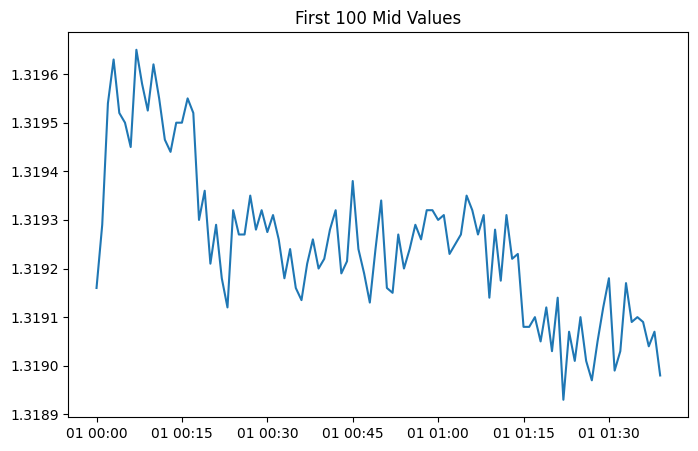

In [ ]:
# TODO Question 1: plot the first 100 values
plt.figure(figsize=(8, 5))
plt.plot(mid[:100])
plt.title('First 100 Mid Values')
plt.show()

In [ ]:
# TODO Question 2: compute returns using mid values and dropping NA
mid_returns = mid.dropna()
mid_returns_df = mid_returns.to_frame()
nbreturns = nbobs - 1

rsi_lookbacks = np.concatenate([5 * np.arange(1, 7), [60]])
nbrissignals = len(rsi_lookbacks)

def rsi(close, lookback):
    delta = close.diff()

    # Separate gains and losses
    gain = (delta.where(delta > 0, 0)).rolling(window=lookback).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=lookback).mean()

    # Calculate the Relative Strength (RS)
    rs = gain / loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns={0: 'rsi'}).set_index(close.index)

    return rsi_df

In [ ]:
# TODO Question 3 : loop on the RSI lookbacks to compute rsi using the RSI function above
signals_rsi = pd.DataFrame(index=EUR.index, columns=rsi_lookbacks)
for k in signals_rsi:
    print(k)
    signals_rsi[k] = rsi(mid, lookback=k)
signals_rsi.fillna(0, inplace=True)

def macd(prices, fast_period=12, slow_period=26, signal_period=9):

    # Calculate the fast and slow EMAs
    ema_fast = prices.ewm(span=fast_period, adjust=False).mean()
    ema_slow = prices.ewm(span=slow_period, adjust=False).mean()

    # Calculate the MACD line
    macd_line = ema_fast - ema_slow

    # Calculate the signal line
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()

    # Calculate the MACD histogram
    macd_histogram = macd_line - signal_line

    # Create a DataFrame to hold the results
    macd_df = pd.DataFrame({
        'MACD': macd_line,
        'MACD_Signal': signal_line,
        'Histogram': macd_histogram
    })

    return macd_df

5
10
15
20
25
30
60


In [ ]:
# TODO Question 4: compute MACD
macd = macd(mid, fast_period=12, slow_period=26, signal_period=9)
macd.fillna(0, inplace=True)

In [ ]:
# Set up variables
predictionHistory = 60

# TODO Question 5: compute future returns
returns_tobemodelled = mid.iloc[2*predictionHistory:nbobs].values / mid.iloc[0:-2*predictionHistory].values - 1
Y = returns_tobemodelled

# Combine MACD and RSI signals
Xinit = pd.concat([macd['MACD_Signal'], signals_rsi], axis=1)




In [ ]:
# TODO Question 6: build X so that it is the same size as Y and data are well specified
X = Xinit.iloc[predictionHistory:nbobs-predictionHistory]
X.columns = X.columns.astype(str)
Y_df = pd.DataFrame(Y, index=X.index, columns=['Y'])

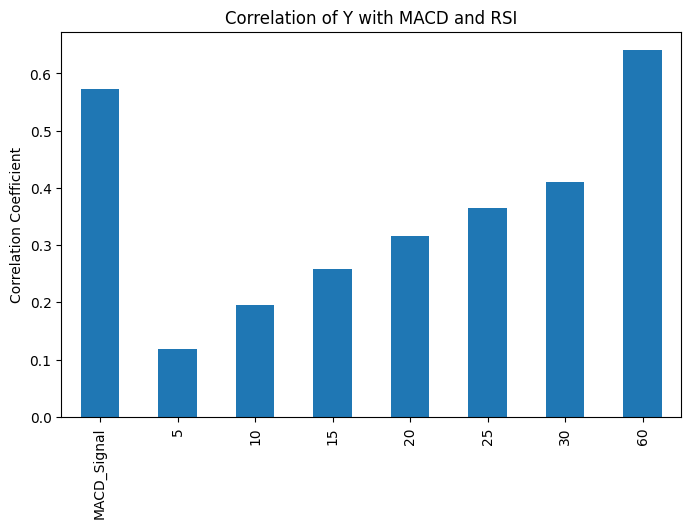

In [ ]:
# TODO Question 7: plot correlations of Y with X
all_data_df = pd.concat([Xinit,Y_df], axis=1)
correlations = all_data_df.corr()['Y']
correlations = correlations.drop('Y')
plt.figure(figsize=(8, 5))
correlations.plot(kind='bar')
plt.title('Correlation of Y with MACD and RSI')
plt.ylabel('Correlation Coefficient')

# Preprocessing: normalization
Ycen = Y - Y.mean()
scaler = StandardScaler()
Xnorm = scaler.fit_transform(X)


In [ ]:
# OLS
linModelFull = LinearRegression().fit(Xnorm, Y)
# TODO Question 8: make predictions (in-sample) on the full dataset
prediction_full_ols = linModelFull.predict(Xnorm)

In [ ]:
# LASSO
lasso = LassoCV(cv=5).fit(Xnorm, Ycen)
# TODO Question 9: make predictions (in-sample) on the full dataset
prediction_full_lasso = lasso.predict(Xnorm) + Y.mean()

[Text(0.49725877192982454, 0.9375, 'x[7] <= 50.017\nsquared_error = 0.0\nsamples = 375720\nvalue = 0.0'),
 Text(0.19188596491228072, 0.8125, 'x[7] <= 42.077\nsquared_error = 0.0\nsamples = 185873\nvalue = -0.0'),
 Text(0.34457236842105265, 0.875, 'True  '),
 Text(0.05263157894736842, 0.6875, 'x[0] <= -0.0\nsquared_error = 0.0\nsamples = 34068\nvalue = -0.001'),
 Text(0.03508771929824561, 0.5625, 'squared_error = 0.0\nsamples = 6090\nvalue = -0.002'),
 Text(0.07017543859649122, 0.5625, 'x[0] <= -0.0\nsquared_error = 0.0\nsamples = 27978\nvalue = -0.001'),
 Text(0.03508771929824561, 0.4375, 'x[7] <= 39.005\nsquared_error = 0.0\nsamples = 10358\nvalue = -0.001'),
 Text(0.017543859649122806, 0.3125, 'squared_error = 0.0\nsamples = 5180\nvalue = -0.002'),
 Text(0.05263157894736842, 0.3125, 'squared_error = 0.0\nsamples = 5178\nvalue = -0.001'),
 Text(0.10526315789473684, 0.4375, 'x[6] <= 44.771\nsquared_error = 0.0\nsamples = 17620\nvalue = -0.001'),
 Text(0.08771929824561403, 0.3125, 'x[0]

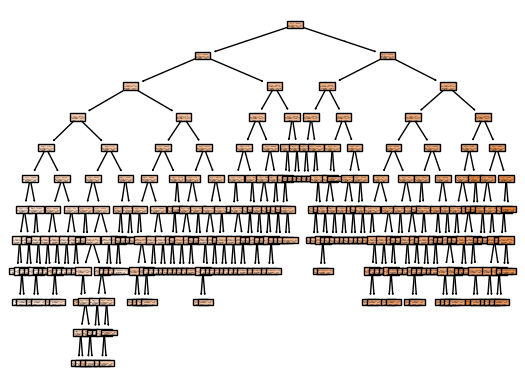

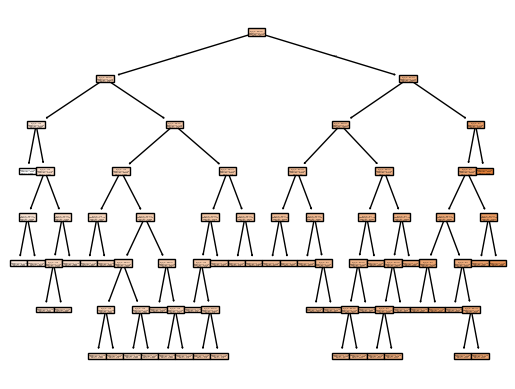

In [ ]:
# Regression tree
tree_basic = DecisionTreeRegressor().fit(X, Y)
# TODO Question 10: add constraints on the tree then plot
# TODO Constraints: first alternative tree has impurity parameter set at 1e-10
# TODO Constraints: second alternative tree has impurity parameter set at 1e-10 and min sample size set at 3750
tree_cp = DecisionTreeRegressor(min_impurity_decrease=1e-10).fit(X, Y)
plt.figure()
tree.plot_tree(tree_cp, filled=True)
tree_split = DecisionTreeRegressor(min_impurity_decrease=1e-10, min_samples_leaf=3750).fit(X, Y)
plt.figure()
tree.plot_tree(tree_split, filled=True)

In [ ]:
# TODO Question 11: make predictions using the most constrained tree
prediction_full_tree = tree_split.predict(X)


In [ ]:
# TODO Question 12: go long (resp. short) when prediction is positive (resp. negative)

# Naive backtests
mid_returns_for_positions = mid_returns.iloc[2 * predictionHistory-1:]
positions_ols_df = pd.DataFrame(index=mid_returns_for_positions.index, columns=['Mid'])
positions_tree_df = positions_ols_df.copy()

offset = len(prediction_full_ols) - len(positions_ols_df.index)
prediction_full_ols_series = pd.Series(prediction_full_ols[offset:], index=positions_ols_df.index)
prediction_full_tree_series = pd.Series(prediction_full_tree[offset:], index=positions_tree_df.index)

# TODO Question 12: go long (resp. short) when prediction is positive (resp. negative)
positions_ols_df.loc[prediction_full_ols_series > 0, 'Mid'] = 1
positions_ols_df.loc[prediction_full_ols_series < 0, 'Mid'] = -1
positions_ols_df.loc[prediction_full_ols_series == 0, 'Mid'] = 0

positions_tree_df.loc[prediction_full_tree_series > 0, 'Mid'] = 1
positions_tree_df.loc[prediction_full_tree_series < 0, 'Mid'] = -1
positions_tree_df.loc[prediction_full_tree_series == 0, 'Mid'] = 0

positions_ols_df.fillna(0, inplace=True)
positions_tree_df.fillna(0,inplace=True)

ValueError: Length of values (375720) does not match length of index (375721)

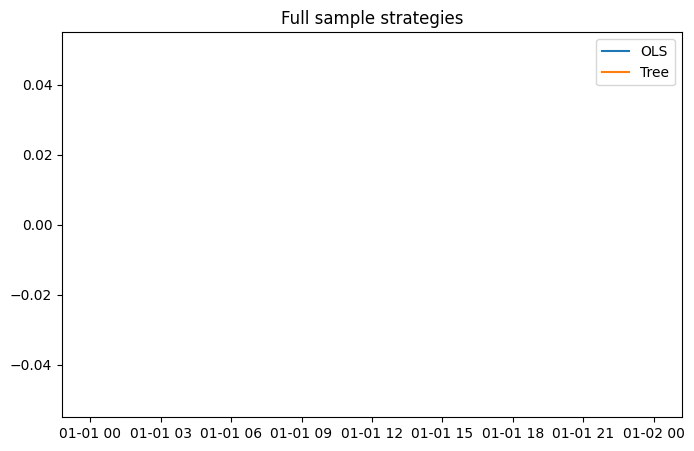

In [ ]:
# TODO Question 13: build returns and cumulative returns of the in-sample strategies, then plot
naive_fullsample_ols_returns_df = positions_ols_df * mid_returns_df.iloc[2 * predictionHistory - 1:]
naive_fullsample_ols_cumreturns_df = (1 + naive_fullsample_ols_returns_df).cumprod()

naive_fullsample_tree_returns_df = positions_tree_df * mid_returns_df.iloc[2 * predictionHistory - 1:]
naive_fullsample_tree_cumreturns_df = (1 + naive_fullsample_tree_returns_df).cumprod()

plt.figure(figsize=(8, 5))
plt.plot(naive_fullsample_ols_cumreturns_df, label='OLS')
plt.plot(naive_fullsample_tree_cumreturns_df, label='Tree')
plt.title("Full sample strategies")
plt.legend()
plt.show()


#Partie 2

In [ ]:
!pip install qpsolvers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 2.0 MB/s eta 0:00:00


In [ ]:
# %% Cell 1: Imports and Setup for HRP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from qpsolvers import solve_qp

cm = plt.colormaps.get_cmap('tab20')


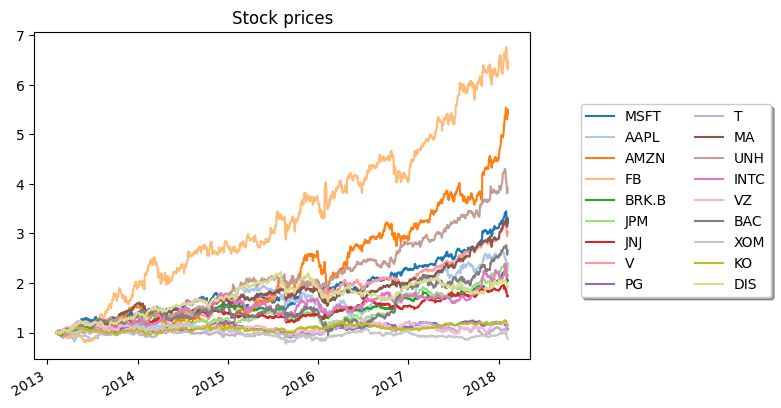

                A    AAL     AAP      AAPL    ABBV    ABC    ABT     ACN  \
2013-02-08  45.08  14.75   78.90   67.8542   36.25  46.89  34.41   73.31   
2013-02-11  44.60  14.46   78.39   68.5614   35.85  46.76  34.26   73.07   
2013-02-12  44.62  14.27   78.60   66.8428   35.42  46.96  34.30   73.37   
2013-02-13  44.75  14.66   78.97   66.7156   35.27  46.64  34.46   73.56   
2013-02-14  44.58  13.99   78.84   66.6556   36.57  46.77  34.70   73.13   
...           ...    ...     ...       ...     ...    ...    ...     ...   
2018-02-01  72.83  53.88  117.29  167.7800  116.34  99.29  62.18  160.46   
2018-02-02  71.25  52.10  113.93  160.5000  115.17  96.02  61.69  156.90   
2018-02-05  68.22  49.76  109.86  156.4900  109.51  91.90  58.73  151.83   
2018-02-06  68.45  51.18  112.20  163.0300  111.20  91.54  58.86  154.69   
2018-02-07  68.06  51.40  109.93  159.5400  113.62  94.22  58.67  155.15   

              ADBE    ADI  ...     XL   XLNX    XOM   XRAY    XRX    XYL  \
2013-02-08 

In [ ]:
# %% Cell 2: Data Import and Preprocessing
# Read the CSV file (adjust file path if needed)
stocks = pd.read_csv("/content/Data_Clustering.csv", index_col=0, sep=";")
stocks.index = pd.to_datetime(stocks.index, format="%d/%m/%Y")
dates = stocks.index

# Select asset columns (ensure the names match your file)
names = ["MSFT", "AAPL", "AMZN", "FB", "BRK.B", "JPM", "JNJ", "V", "PG",
         "T", "MA", "UNH", "INTC", "VZ", "BAC", "XOM", "KO", "DIS"]
values_all = stocks[names]
values_all.index = dates

# Rescale prices (base = first observation)
values_rescaled = values_all / values_all.iloc[0]
values_rescaled.plot(title="Stock prices", legend=True, color=cm.colors)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 0.8), fancybox=True, shadow=True, ncol=2)
plt.show()
print(stocks)

In [ ]:
# %% Cell 3: Helper Functions (Returns, CAGR, Volatility)
def compute_return(prices):
    """Compute simple returns; first return is 0."""
    return prices.pct_change().fillna(0)

def compute_CAGR(price, ann_multiple=252):
    n = len(price)
    cagr = (price.iloc[-1] / price.iloc[0]) ** (ann_multiple / n) - 1
    return cagr

def compute_vol(price, ann_multiple=252):
    ret = price / price.shift(1) - 1  # Calculate returns
    n = len(price)
    mu = np.nanmean(ret)
    sigma_daily = np.sqrt(np.nansum((ret - mu) ** 2) / (n - 1))
    sigma = np.sqrt(ann_multiple) * sigma_daily
    return sigma


In [ ]:
# %% Cell 4: Prepare Returns and Initialize Rebalancing and Weight DataFrames
# Compute daily returns for each asset
returns = values_all.apply(compute_return)
num_obs, num_assets = returns.shape

# Define rebalancing indices (from 300 to (n-21) by steps of 21)
rebalance_indices = np.arange(300, num_obs - 21, 21)

# Initialize DataFrames for portfolio weights (one row per day)
weights_MVO     = pd.DataFrame(0, index=returns.index, columns=names)
weights_MVO_L2  = pd.DataFrame(0, index=returns.index, columns=names)
weights_RP      = pd.DataFrame(0, index=returns.index, columns=names)
weights_HRP     = pd.DataFrame(0, index=returns.index, columns=names)

TC_cost = 0.0005


/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
<ipython-input-10-c96f45b8f2c3>:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.07912327545993975' has dtype incompatible with int64, please explici

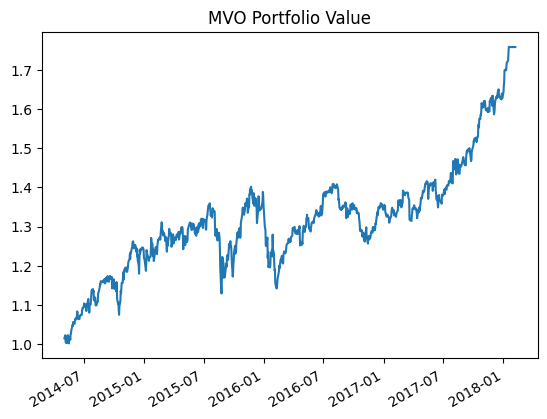

<Figure size 640x480 with 0 Axes>

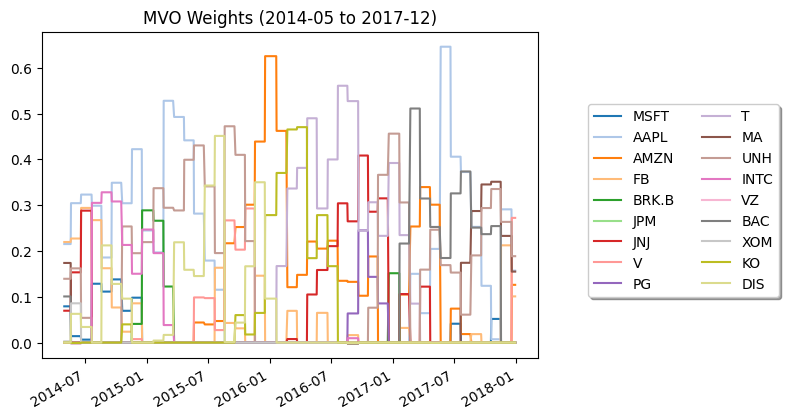

In [ ]:
# Q1: Classical Mean-Variance Optimization (MVO)
# =============================================================================
gamma = 0.05

for ind in rebalance_indices:
    # Define the estimation window: last 252 days (including current day)
    window_slice = slice(ind - 251, ind + 1)
    values_tmp = values_all.iloc[window_slice]
    returns_tmp = returns.iloc[window_slice]

    # Compute expected returns (CAGR) for each asset
    Mus_tmp = compute_CAGR(values_tmp)
    # Annualized covariance matrix
    Sigma_tmp = returns_tmp.cov() * 252

    P = Sigma_tmp.values
    q = -gamma * Mus_tmp.values


    A = np.ones((1, num_assets))
    b = np.array([1.0])

    G = -np.eye(len(Mus_tmp))
    h = np.zeros(len(Mus_tmp))




    weights_QP = solve_qp(P, q, G, h, A, b,solver="osqp")

    # Apply these weights for the next 22 days (if within bounds)
    start = ind + 1
    end = min(ind + 22, num_obs)
    for t in range(start, end):
        weights_MVO.iloc[t] = weights_QP

# Compute portfolio returns and adjust for transaction costs
ptf_MVO = (weights_MVO * returns).sum(axis=1)
weights_diff = weights_MVO.diff().abs().sum(axis=1).fillna(0)
return_ptf_MVO = ptf_MVO - weights_diff * TC_cost
return_ptf_MVO = return_ptf_MVO.fillna(0)
value_ptf_MVO = (return_ptf_MVO + 1).cumprod()
value_ptf_MVO = value_ptf_MVO[value_ptf_MVO.index > '2014-05']

plt.figure()
value_ptf_MVO.plot(title="MVO Portfolio Value")
plt.show()

plt.figure()
weights_MVO.loc["2014-05-01":"2017-12-31"].plot(title="MVO Weights (2014-05 to 2017-12)", color=cm.colors)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 0.8), fancybox=True, shadow=True, ncol=2)
plt.show()


/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/qpsolvers/conversions/ensure_sparse_matrices.py:24: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
<ipython-input-11-5d0a32b50aec>:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.057984723925920814' has dtype incompatible with int64, please explic

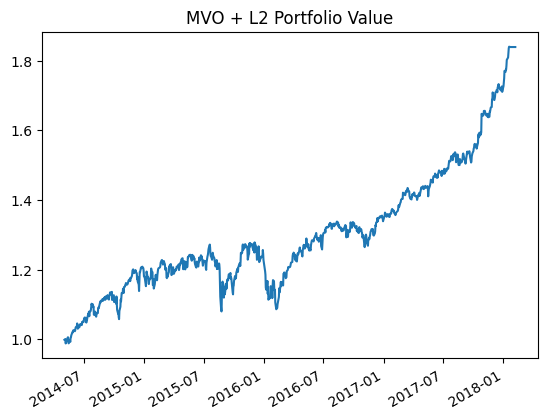

<Figure size 640x480 with 0 Axes>

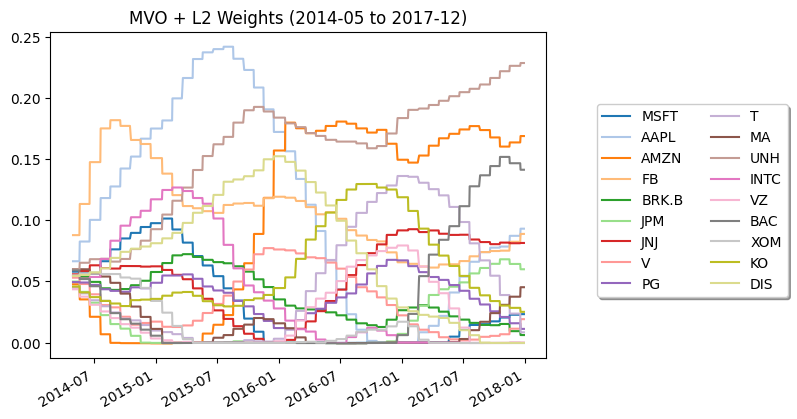

In [ ]:
# %% Cell 6: Q2 – MVO with L2 Regularisation (Ridge)
gamma = 0.05
rho = 0.5
weights_old = np.ones(num_assets) / num_assets

for ind in rebalance_indices:
    window_slice = slice(ind - 251, ind + 1)
    values_tmp = values_all.iloc[window_slice]
    returns_tmp = returns.iloc[window_slice]

    Mus_tmp = values_tmp.apply(compute_CAGR)
    Sigma_tmp = returns_tmp.cov().values * 252

    # The L2 term: add ρ‖w - w_old‖² = ρ (wᵀw - 2 w_oldᵀw + const)
    P = Sigma_tmp + 2 * rho * np.eye(num_assets)
    q = -gamma * Mus_tmp.values - 2 * rho * weights_old

    A = np.ones((1, num_assets))
    b = np.array([1])

    G = -np.eye(num_assets)
    h = np.zeros(num_assets)

    weights_ridge = solve_qp(P, q, G, h, A, b, solver="osqp")

    start = ind + 1
    end = min(ind + 22, num_obs)
    for t in range(start, end):
        weights_MVO_L2.iloc[t] = weights_ridge
    weights_old = weights_ridge

ptf_MVO_L2 = (weights_MVO_L2 * returns).sum(axis=1)
weights_diff = weights_MVO_L2.diff().abs().sum(axis=1).fillna(0)
return_ptf_MVO_L2 = ptf_MVO_L2 - weights_diff * TC_cost
return_ptf_MVO_L2 = return_ptf_MVO_L2.fillna(0)
value_ptf_MVO_L2 = (return_ptf_MVO_L2 + 1).cumprod()
value_ptf_MVO_L2 = value_ptf_MVO_L2[value_ptf_MVO_L2.index > '2014-05']

plt.figure()
value_ptf_MVO_L2.plot(title="MVO + L2 Portfolio Value")
plt.show()

plt.figure()
weights_MVO_L2.loc["2014-05-01":"2017-12-31"].plot(title="MVO + L2 Weights (2014-05 to 2017-12)", color=cm.colors)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 0.8), fancybox=True, shadow=True, ncol=2)
plt.show()


<ipython-input-12-9788d0c9c19d>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.05089100180193557' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights_RP.iloc[t] = weight_rp
<ipython-input-12-9788d0c9c19d>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0855578456759943' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights_RP.iloc[t] = weight_rp
<ipython-input-12-9788d0c9c19d>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.03551722770092749' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights_RP.iloc[t] = weight_rp
<ipython-input-12-9788d0c9c19d>:54: FutureWarning: Setting an item of incompatible 

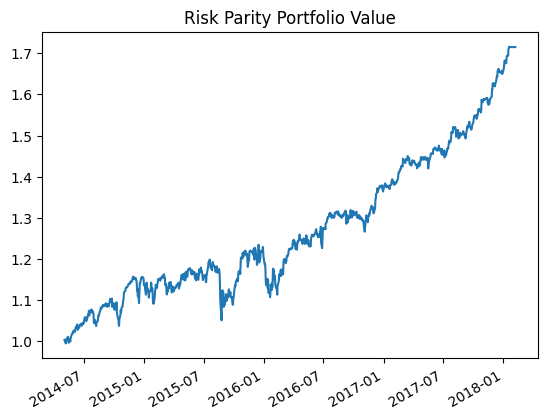

<Figure size 640x480 with 0 Axes>

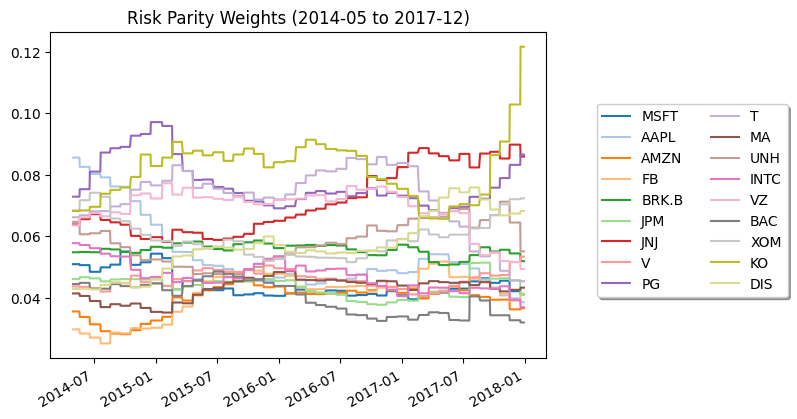

In [ ]:
# Q3 – Classical Risk Parity (RP)
def solve_risk_parity(Sigma):
    """
    Solve the risk parity optimization:
      minimize   -sum(log(w))
      subject to sqrt(w' Σ w) ≤ riskTarget,
      with lower bounds on w.
    The solution is then normalized so that sum(w) = 1.
    """
    numAssets = Sigma.shape[1]

    def objective(w):
        return -np.sum(np.log(w))

    def objective_jacobian(w):
        return -1.0 / w

    def constraint(w):
        risk = np.sqrt(np.dot(w, np.dot(Sigma, w)))
        return riskTarget - risk

    def constraint_jacobian(w):
        risk = np.sqrt(np.dot(w, np.dot(Sigma, w)))
        jac = - np.dot(Sigma, w) / risk
        return jac

    bounds = [(1e-6, 1) for _ in range(numAssets)]
    cons = {'type': 'ineq',
            'fun': constraint,
            'jac': constraint_jacobian}

    x0 = np.ones(numAssets) / numAssets
    riskTarget = np.sqrt(np.dot(x0, np.dot(Sigma, x0)))
    res = minimize(fun=objective,
                   x0=x0,
                   method='SLSQP',
                   jac=objective_jacobian,
                   bounds=bounds,
                   constraints=cons,
                   options={'maxiter': 500, 'disp': False})
    w_opt = res.x
    return w_opt / w_opt.sum()

for ind in rebalance_indices:
    window_slice = slice(ind - 251, ind + 1)
    returns_tmp = returns.iloc[window_slice]
    Sigma_tmp = returns_tmp.cov().values * 252

    weight_rp = solve_risk_parity(Sigma_tmp)

    start = ind + 1
    end = min(ind + 22, num_obs)
    for t in range(start, end):
        weights_RP.iloc[t] = weight_rp

ptf_RP = (weights_RP * returns).sum(axis=1)
weights_diff = weights_RP.diff().abs().sum(axis=1).fillna(0)
return_ptf_RP = ptf_RP - weights_diff * TC_cost
return_ptf_RP = return_ptf_RP.fillna(0)
value_ptf_RP = (return_ptf_RP + 1).cumprod()
value_ptf_RP = value_ptf_RP[value_ptf_RP.index > '2014-05']

plt.figure()
value_ptf_RP.plot(title="Risk Parity Portfolio Value")
plt.show()

plt.figure()
weights_RP.loc["2014-05-01":"2017-12-31"].plot(title="Risk Parity Weights (2014-05 to 2017-12)", color=cm.colors)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 0.8), fancybox=True, shadow=True, ncol=2)
plt.show()


<ipython-input-13-fa2e3a150d3a>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.22040471 0.19247432 0.21626553 0.213761   0.15709445]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Weight_tmp.iloc[idx] = w_cluster.values
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
<ipython-input-13-fa2e3a150d3a>:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.04312959148300487' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Weight_final.iloc[i] = rpWeight[cluster - 1] * Weight_tmp.iloc[i]
<ipython-input-13-fa2e3a150d3a>:54: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an 

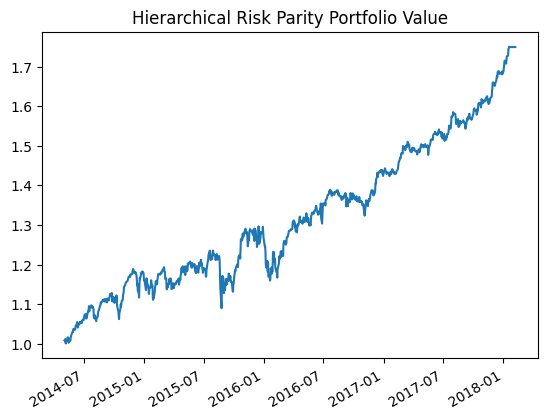

<Figure size 640x480 with 0 Axes>

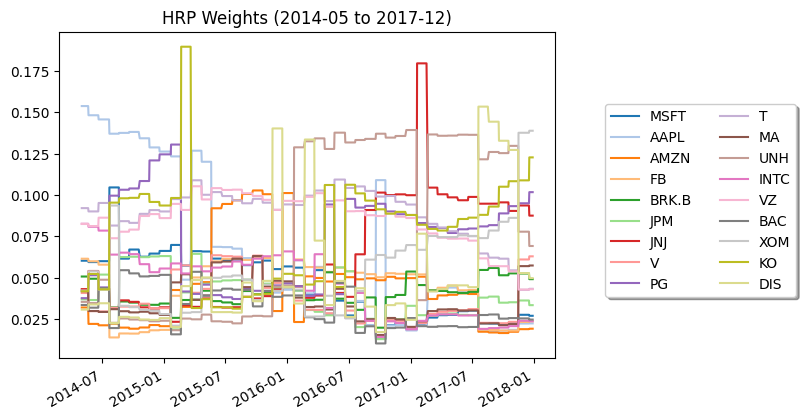

In [ ]:
# %% Cell 8: Q4 – Hierarchical Risk Parity (HRP)
for ind in rebalance_indices:
    window_slice = slice(ind - 251, ind + 1)
    returns_tmp = returns.iloc[window_slice]

    # Compute asset volatility and covariance
    vol_tmp = returns_tmp.std(ddof=1)
    Sigma_tmp = returns_tmp.cov().values * 252
    Weight_tmp = pd.Series(0, index=names)

    # Hierarchical clustering based on correlations
    corr = returns_tmp.corr()
    distance_matrix = np.sqrt(0.5 * (1 - corr))
    condensed_distance = squareform(distance_matrix, checks=False)
    Z = linkage(condensed_distance, method='ward')

    # Cut the dendrogram into 7 clusters
    clusters = fcluster(Z, t=7, criterion='maxclust')

    # For each cluster, determine weights using inverse volatility and compute a “cluster return”
    recap = {}
    for cluster in np.unique(clusters):
        idx = np.where(clusters == cluster)[0]
        if len(idx) == 1:
            Weight_tmp.iloc[idx[0]] = 1
            recap[cluster] = returns_tmp.iloc[:, idx[0]]
        else:
            vols = vol_tmp.iloc[idx]
            w_cluster = (1 / vols) / (1 / vols).sum()
            Weight_tmp.iloc[idx] = w_cluster.values
            cluster_return = (returns_tmp.iloc[:, idx] * w_cluster.values).sum(axis=1)
            recap[cluster] = cluster_return

    # Combine cluster returns and compute covariance for clusters
    return_cluster = pd.DataFrame(recap, index=returns_tmp.index)
    Sigma_cluster = return_cluster.cov().values * 252

    num_clusters = return_cluster.shape[1]
    weights_ini = np.ones(num_clusters) / num_clusters

    # Solve risk parity optimization for clusters
    rpWeight = solve_risk_parity(Sigma_cluster)

    # Allocate final asset weights: for asset in cluster i, weight = rpWeight[i] * Weight_tmp
    Weight_final = pd.Series(0, index=names)
    for cluster in np.unique(clusters):
        idx = np.where(clusters == cluster)[0]
        for i in idx:
            Weight_final.iloc[i] = rpWeight[cluster - 1] * Weight_tmp.iloc[i]

    start = ind + 1
    end = min(ind + 22, num_obs)
    for t in range(start, end):
        weights_HRP.iloc[t] = Weight_final.values

ptf_HRP = (weights_HRP * returns).sum(axis=1)
weights_diff = weights_HRP.diff().abs().sum(axis=1).fillna(0)
return_ptf_HRP = ptf_HRP - weights_diff * TC_cost
return_ptf_HRP = return_ptf_HRP.fillna(0)
value_ptf_HRP = (return_ptf_HRP + 1).cumprod()
value_ptf_HRP = value_ptf_HRP[value_ptf_HRP.index > '2014-05']

plt.figure()
value_ptf_HRP.plot(title="Hierarchical Risk Parity Portfolio Value")
plt.show()

plt.figure()
weights_HRP.loc["2014-05-01":"2017-12-31"].plot(title="HRP Weights (2014-05 to 2017-12)", color=cm.colors)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 0.8), fancybox=True, shadow=True, ncol=2)
plt.show()


<Figure size 640x480 with 0 Axes>

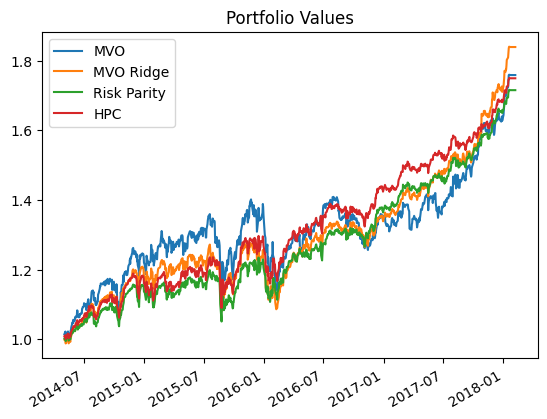

Sharpe Ratios:
MVO            0.9790
MVO Ridge      1.2936
Risk Parity    1.3213
HPC            1.3275
dtype: float64
Max Drawdowns:
MVO           -18.5
MVO Ridge     -15.1
Risk Parity   -12.3
HPC           -11.8
dtype: float64 %


<Figure size 640x480 with 0 Axes>

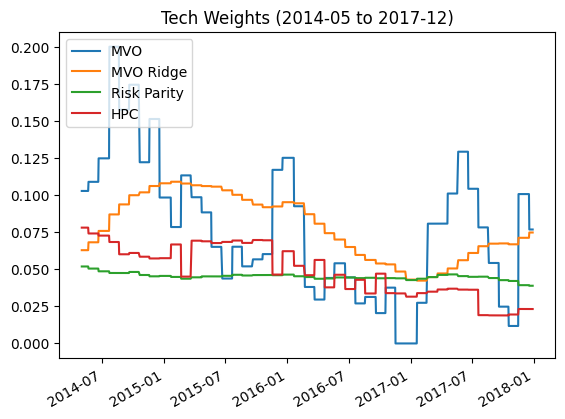

In [ ]:
# %% Cell 9: Q5 – Comparisons: Sharpe Ratios, Max Drawdown, and Tech Weights
def compute_SR(price, ret_without_risk=0.0, multiplicator=252):
    """Compute Sharpe ratio given a price series."""
    CAGR = compute_CAGR(price, multiplicator)
    vol = compute_vol(price, multiplicator)
    return (CAGR - ret_without_risk) / vol if vol != 0 else np.nan

def compute_MDD(price):
    """Compute maximum drawdown from a price series."""
    cummax = price.cummax()
    drawdown = price / cummax - 1
    return drawdown.min()

# Combine portfolio values from all approaches
all_ptf = pd.concat([value_ptf_MVO, value_ptf_MVO_L2, value_ptf_RP, value_ptf_HRP], axis=1)
all_ptf.columns = ['MVO', 'MVO Ridge', 'Risk Parity', 'HPC']

plt.figure()
all_ptf.plot(title="Portfolio Values")
plt.legend(loc="upper left")
plt.show()

# Compute Sharpe Ratios and Maximum Drawdowns
SRs = all_ptf.apply(lambda x: compute_SR(x), axis=0)
print("Sharpe Ratios:")
print(np.round(SRs, 4))
MDDs = all_ptf.apply(lambda x: compute_MDD(x), axis=0)
print("Max Drawdowns:")
print(np.round(MDDs * 100, 1), '%')

# Compare the allocation of technology stocks (e.g., AMZN, FB, AAPL, MSFT, INTC)
tech_stocks = ['AMZN', 'FB', 'AAPL', 'MSFT', 'INTC']
weights_MVO_Tech    = weights_MVO[tech_stocks].mean(axis=1)
weights_MVO_L2_Tech = weights_MVO_L2[tech_stocks].mean(axis=1)
weights_RP_Tech     = weights_RP[tech_stocks].mean(axis=1)
weights_HRP_Tech    = weights_HRP[tech_stocks].mean(axis=1)

all_tech_weights = pd.concat([weights_MVO_Tech, weights_MVO_L2_Tech,
                              weights_RP_Tech, weights_HRP_Tech], axis=1)
all_tech_weights.columns = ['MVO', 'MVO Ridge', 'Risk Parity', 'HPC']

plt.figure()
all_tech_weights.loc["2014-05-01":"2017-12-31"].plot(title="Tech Weights (2014-05 to 2017-12)")
plt.legend(loc="upper left")
plt.show()
